In [1]:
!pip install --upgrade albumentations opencv-python-headless==4.12.0.88

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/OCT_Model/
%ls oct_slices

/content/drive/MyDrive/OCT_Model
HC/  MS/


In [4]:
DATA_DIR = "/content/drive/MyDrive/OCT_Model/oct_slices"

In [ ]:
import os, random, math, time
from glob import glob
from pathlib import Path
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import timm
from tqdm import tqdm

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt

In [ ]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [ ]:
# Importing data from DATA_DIR/HC/*.png and DATA_DIR/MS/*.png
hc_files = sorted(glob(os.path.join(DATA_DIR, "HC", "*.png")))
ms_files = sorted(glob(os.path.join(DATA_DIR, "MS", "*.png")))

print(f"Found {len(hc_files)} HC images and {len(ms_files)} MS images. Total = {len(hc_files)+len(ms_files)}")

items = [(p, 0) for p in hc_files] + [(p, 1) for p in ms_files]
random.shuffle(items)

paths = [p for p,_ in items]
labels = [l for _,l in items]

Found 686 HC images and 1029 MS images. Total = 1715


In [8]:
TOTAL = len(paths)
TRAIN_DESIRED = 1200
assert TRAIN_DESIRED < TOTAL, "TRAIN_DESIRED must be less than total images"

train_paths, test_paths, train_labels, test_labels = train_test_split(
    paths, labels, train_size=TRAIN_DESIRED, stratify=labels, random_state=SEED
)

print("Train:", len(train_paths), "Test:", len(test_paths))

Train: 1200 Test: 515


In [ ]:

train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.2, stratify=train_labels, random_state=SEED
)
print("After internal split -> Train:", len(train_paths), "Val:", len(val_paths), "Test:", len(test_paths))

After internal split -> Train: 960 Val: 240 Test: 515


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

print("albumentations version:", A.__version__)  # should show 2.x 

albumentations version: 2.0.8


In [ ]:
IMAGE_SIZE = 300

train_transform = A.Compose([
    A.RandomResizedCrop(size=(IMAGE_SIZE, IMAGE_SIZE), scale=(0.7, 1.0), ratio=(0.9, 1.1), p=1.0),

    A.HorizontalFlip(p=0.5),
    # A.VerticalFlip(p=0.3),          
    A.RandomRotate90(p=0.4),

    A.Affine(
        translate_percent=(-0.06, 0.06),
        scale=(0.92, 1.08),
        rotate=(-15, 15),
        p=0.5
    ),

    A.OneOf([
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=1.0),
        A.ElasticTransform(alpha=1.0, sigma=50.0, approximate=False, same_dxdy=False, p=1.0),
    ], p=0.3),

    A.RandomBrightnessContrast(brightness_limit=0.25, contrast_limit=0.25, p=0.6),

    A.GaussNoise(std_range=(0.01, 0.03), mean_range=(0.0, 0.0), per_channel=True, p=0.3),

    A.CoarseDropout(
        num_holes_range=(1, 8),
        hole_height_range=(0.02, 0.07),
        hole_width_range=(0.02, 0.07),
        p=0.4
    ),

    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

test_transform = val_transform

In [ ]:
class OCTSliceDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        p = self.paths[idx]
        img = cv2.imread(p)             # BGR
        if img is None:
            raise RuntimeError(f"Failed to read image: {p}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]
        if self.transform:
            augmented = self.transform(image=img)
            img = augmented["image"]
        return img, torch.tensor(label, dtype=torch.float32)

BATCH_SIZE = 16 
num_workers = 2

train_ds = OCTSliceDataset(train_paths, train_labels, transform=train_transform)
val_ds   = OCTSliceDataset(val_paths, val_labels, transform=val_transform)
test_ds  = OCTSliceDataset(test_paths, test_labels, transform=test_transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)

print("Loaders ready. Example batch shapes:")
xb, yb = next(iter(train_loader))
print(xb.shape, yb.shape)


Loaders ready. Example batch shapes:
torch.Size([16, 3, 300, 300]) torch.Size([16])


In [ ]:
# def show_batch(dl):
#     xb, yb = next(iter(dl))
#     xb = xb.permute(0,2,3,1).cpu().numpy()
#     fig, axes = plt.subplots(2,4, figsize=(12,6))
#     axes = axes.flatten()
#     for i in range(min(len(xb),8)):
#         axes[i].imshow((xb[i]*np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])))
#         axes[i].set_title(f"label={int(yb[i].item())}")
#         axes[i].axis('off')
#     plt.show()

# show_batch(train_loader)

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

MODEL_NAME = "tf_efficientnet_b4_ns"   # good tradeoff; options: 'resnet50', 'convnext_tiny', 'tf_efficientnet_b4_ns'
model = timm.create_model(MODEL_NAME, pretrained=True, num_classes=1)  # binary -> 1 logit
model = model.to(DEVICE)
# print(model)


Device: cuda


/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name tf_efficientnet_b4_ns to current tf_efficientnet_b4.ns_jft_in1k.
  model = create_fn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

In [ ]:
import torch
from contextlib import nullcontext

# Loss, optimizer, scheduler 
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
EPOCHS = 30
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

use_amp = torch.cuda.is_available()

def make_scaler(enabled: bool):
    if not enabled:
        return None
    try:
        return torch.amp.GradScaler(enabled=True)
    except Exception:
        try:
            return torch.cuda.amp.GradScaler(enabled=True)
        except Exception:
            return None

scaler = make_scaler(use_amp)

def scaler_is_enabled(scaler_obj):
    if scaler_obj is None:
        return False
    try:
        return bool(scaler_obj.is_enabled())
    except Exception:
        return True

def get_autocast_ctx(enabled: bool, device: torch.device):
    if not enabled:
        return nullcontext()
    try:
        return torch.amp.autocast(device_type="cuda" if device.type == "cuda" else "cpu", enabled=True)
    except TypeError:
        try:
            return torch.amp.autocast(enabled=True)
        except TypeError:
            return nullcontext()

print("use_amp:", use_amp, "scaler created:", scaler is not None, "scaler_enabled:", scaler_is_enabled(scaler))

use_amp: True scaler created: True scaler_enabled: True


In [ ]:
# === Training & validation functions using the helpers ===
def train_one_epoch(model, loader, optimizer, criterion, device, scaler_obj):
    model.train()
    running_loss = 0.0
    preds_list = []
    labels_list = []

    enabled = scaler_is_enabled(scaler_obj)
    autocast_ctx = None  
    loop = tqdm(loader, desc="train", leave=False)
    for imgs, labels in loop:
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        with get_autocast_ctx(enabled, device):
            logits = model(imgs).squeeze(1)
            loss = criterion(logits, labels)

        if enabled:
            scaler_obj.scale(loss).backward()
            scaler_obj.step(optimizer)
            scaler_obj.update()
        else:
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        probs = torch.sigmoid(logits).detach().cpu().numpy()
        preds_list.extend(probs.tolist())
        labels_list.extend(labels.detach().cpu().numpy().tolist())

    avg_loss = running_loss / len(loader.dataset)
    preds_bin = [1 if p >= 0.5 else 0 for p in preds_list]
    acc = accuracy_score(labels_list, preds_bin)
    return avg_loss, acc

def validate(model, loader, criterion, device, scaler_obj):
    model.eval()
    running_loss = 0.0
    preds_list = []
    labels_list = []

    enabled = scaler_is_enabled(scaler_obj)
    with torch.no_grad():
        loop = tqdm(loader, desc="val", leave=False)
        for imgs, labels in loop:
            imgs = imgs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            with get_autocast_ctx(enabled, device):
                logits = model(imgs).squeeze(1)
                loss = criterion(logits, labels)

            running_loss += loss.item() * imgs.size(0)
            probs = torch.sigmoid(logits).cpu().numpy()
            preds_list.extend(probs.tolist())
            labels_list.extend(labels.cpu().numpy().tolist())

    avg_loss = running_loss / len(loader.dataset)
    preds_bin = [1 if p >= 0.5 else 0 for p in preds_list]
    acc = accuracy_score(labels_list, preds_bin)
    return avg_loss, acc, preds_list, labels_list

In [ ]:
# === Training loop with checkpointing ===
best_val_loss = float('inf')
best_epoch = -1
save_path = "/content/drive/MyDrive/OCT_Model/best_model.pth"

for epoch in range(1, EPOCHS+1):
    print(f"\n=== Epoch {epoch}/{EPOCHS} ===")
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE, scaler)
    val_loss, val_acc, _, _ = validate(model, val_loader, criterion, DEVICE, scaler)
    print(f"Train loss: {train_loss:.4f}  acc: {train_acc:.4f}")
    print(f"Val   loss: {val_loss:.4f}  acc: {val_acc:.4f}")
    # save best
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        torch.save({
            'model_state': model.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'epoch': epoch
        }, save_path)
        print("Saved best model.")
    scheduler.step()
print(f"Finished training. Best epoch: {best_epoch} val_loss: {best_val_loss:.4f}")


=== Epoch 1/30 ===


Train loss: 1.8212  acc: 0.4958
Val   loss: 1.4613  acc: 0.4792
Saved best model.

=== Epoch 2/30 ===


Train loss: 1.1692  acc: 0.6010
Val   loss: 0.8995  acc: 0.6500
Saved best model.

=== Epoch 3/30 ===


Train loss: 1.0172  acc: 0.6135
Val   loss: 1.2313  acc: 0.6250

=== Epoch 4/30 ===


Train loss: 0.8839  acc: 0.6365
Val   loss: 0.6331  acc: 0.7333
Saved best model.

=== Epoch 5/30 ===


Train loss: 0.7494  acc: 0.6500
Val   loss: 0.5978  acc: 0.7125
Saved best model.

=== Epoch 6/30 ===


Train loss: 0.6838  acc: 0.6802
Val   loss: 0.5250  acc: 0.7375
Saved best model.

=== Epoch 7/30 ===


Train loss: 0.6139  acc: 0.6927
Val   loss: 0.4997  acc: 0.7333
Saved best model.

=== Epoch 8/30 ===


Train loss: 0.6160  acc: 0.7115
Val   loss: 0.6863  acc: 0.6917

=== Epoch 9/30 ===


Train loss: 0.5150  acc: 0.7458
Val   loss: 0.5143  acc: 0.7417

=== Epoch 10/30 ===


Train loss: 0.5154  acc: 0.7667
Val   loss: 0.3756  acc: 0.8167
Saved best model.

=== Epoch 11/30 ===


Train loss: 0.5096  acc: 0.7698
Val   loss: 0.4696  acc: 0.8083

=== Epoch 12/30 ===


Train loss: 0.4739  acc: 0.7781
Val   loss: 0.3299  acc: 0.8500
Saved best model.

=== Epoch 13/30 ===


Train loss: 0.4490  acc: 0.7948
Val   loss: 0.3024  acc: 0.8875
Saved best model.

=== Epoch 14/30 ===


Train loss: 0.4211  acc: 0.8083
Val   loss: 0.3551  acc: 0.8542

=== Epoch 15/30 ===


Train loss: 0.3577  acc: 0.8406
Val   loss: 0.2995  acc: 0.8708
Saved best model.

=== Epoch 16/30 ===


Train loss: 0.3612  acc: 0.8250
Val   loss: 0.4174  acc: 0.8375

=== Epoch 17/30 ===


Train loss: 0.3664  acc: 0.8219
Val   loss: 0.3279  acc: 0.8667

=== Epoch 18/30 ===


Train loss: 0.3134  acc: 0.8615
Val   loss: 0.2612  acc: 0.9042
Saved best model.

=== Epoch 19/30 ===


Train loss: 0.3452  acc: 0.8469
Val   loss: 0.4277  acc: 0.8250

=== Epoch 20/30 ===


Train loss: 0.3218  acc: 0.8562
Val   loss: 0.2625  acc: 0.8875

=== Epoch 21/30 ===


Train loss: 0.3234  acc: 0.8583
Val   loss: 0.2378  acc: 0.9083
Saved best model.

=== Epoch 22/30 ===


Train loss: 0.2948  acc: 0.8688
Val   loss: 0.2338  acc: 0.9083
Saved best model.

=== Epoch 23/30 ===


Train loss: 0.2945  acc: 0.8719
Val   loss: 0.2184  acc: 0.9125
Saved best model.

=== Epoch 24/30 ===


Train loss: 0.2746  acc: 0.8729
Val   loss: 0.2354  acc: 0.8958

=== Epoch 25/30 ===


Train loss: 0.2609  acc: 0.8927
Val   loss: 0.2328  acc: 0.9042

=== Epoch 26/30 ===


Train loss: 0.2736  acc: 0.8719
Val   loss: 0.2157  acc: 0.9125
Saved best model.

=== Epoch 27/30 ===


Train loss: 0.2538  acc: 0.8896
Val   loss: 0.2119  acc: 0.9167
Saved best model.

=== Epoch 28/30 ===


Train loss: 0.2872  acc: 0.8760
Val   loss: 0.2063  acc: 0.9167
Saved best model.

=== Epoch 29/30 ===


Train loss: 0.2682  acc: 0.8885
Val   loss: 0.2014  acc: 0.9125
Saved best model.

=== Epoch 30/30 ===


Train loss: 0.2704  acc: 0.8802
Val   loss: 0.2089  acc: 0.9000
Finished training. Best epoch: 29 val_loss: 0.2014


In [ ]:
# === Load best model and test evaluation ===
ckpt = torch.load("/content/drive/MyDrive/OCT_Model/best_model.pth", map_location=DEVICE)
model.load_state_dict(ckpt['model_state'])
model.to(DEVICE)
model.eval()

all_probs = []
all_labels = []
with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="test"):
        imgs = imgs.to(DEVICE)
        logits = model(imgs).squeeze(1)
        probs = torch.sigmoid(logits).cpu().numpy()
        all_probs.extend(probs.tolist())
        all_labels.extend(labels.cpu().numpy().tolist())

preds_bin = [1 if p>=0.5 else 0 for p in all_probs]

acc = accuracy_score(all_labels, preds_bin)
prec = precision_score(all_labels, preds_bin)
rec = recall_score(all_labels, preds_bin)
f1 = f1_score(all_labels, preds_bin)
try:
    auc = roc_auc_score(all_labels, all_probs)
except Exception:
    auc = None
cm = confusion_matrix(all_labels, preds_bin)

print("Test results:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}  Recall: {rec:.4f}  F1: {f1:.4f}  ROC-AUC: {auc}")
print("Confusion matrix:\n", cm)


test: 100%|██████████| 33/33 [01:04<00:00,  1.95s/it]

Test results:
Accuracy: 0.9165
Precision: 0.9290  Recall: 0.9320  F1: 0.9305  ROC-AUC: 0.9759638043170893
Confusion matrix:
 [[184  22]
 [ 21 288]]


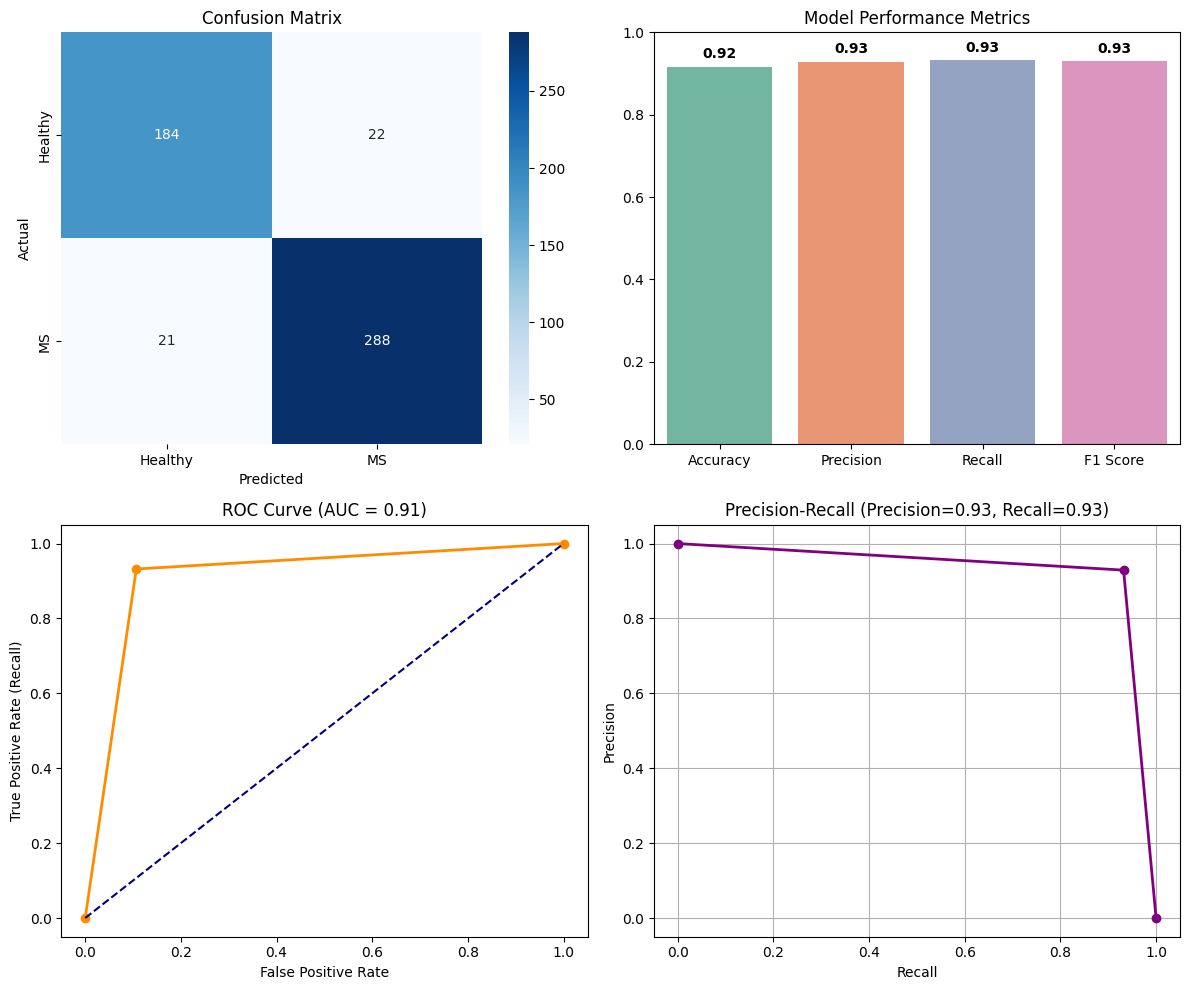

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

TN, FP = cm[0]
FN, TP = cm[1]

y_true = [0]* (TN + FP) + [1]* (FN + TP)
y_pred = [0]*TN + [1]*FP + [0]*FN + [1]*TP

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# === Confusion matrix heatmap ===
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Healthy','MS'], yticklabels=['Healthy','MS'],
            ax=axes[0])
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')
axes[0].set_title('Confusion Matrix')

# === Metrics bar chart ===
metrics = {
    "Accuracy": accuracy_score(y_true, y_pred),
    "Precision": precision_score(y_true, y_pred),
    "Recall": recall_score(y_true, y_pred),
    "F1 Score": f1_score(y_true, y_pred)
}

sns.barplot(x=list(metrics.keys()), y=list(metrics.values()),
            hue=list(metrics.keys()), palette='Set2', legend=False, ax=axes[1])
axes[1].set_ylim(0,1)
axes[1].set_title('Model Performance Metrics')
for i, v in enumerate(metrics.values()):
    axes[1].text(i, v+0.02, f"{v:.2f}", ha='center', fontweight='bold')

# === ROC-AUC (approximation using confusion matrix) ===
TPR = TP / (TP + FN) 
FPR = FP / (FP + TN) 
roc_auc = roc_auc_score(y_true, y_pred)

axes[2].plot([0, FPR, 1], [0, TPR, 1], marker='o', color='darkorange', lw=2)
axes[2].plot([0,1],[0,1],'--', color='navy')
axes[2].set_xlabel('False Positive Rate')
axes[2].set_ylabel('True Positive Rate (Recall)')
axes[2].set_title(f'ROC Curve (AUC = {roc_auc:.2f})')

# === Precision-Recall (approximation using confusion matrix) ===
Precision = TP / (TP + FP)
Recall = TP / (TP + FN)

axes[3].plot([0, Recall, 1], [1, Precision, 0], marker='o', color='purple', lw=2)
axes[3].set_xlabel('Recall')
axes[3].set_ylabel('Precision')
axes[3].set_title(f'Precision-Recall (Precision={Precision:.2f}, Recall={Recall:.2f})')
axes[3].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
def tta_predict(model, img_tensor):
    model.eval()
    t = img_tensor.unsqueeze(0).to(DEVICE)  # single
    with torch.no_grad():
        p0 = torch.sigmoid(model(t).squeeze(1)).cpu().item()
        npimg = t[0].permute(1,2,0).cpu().numpy()  # HWC
        npimg_flip = np.flip(npimg, axis=1).copy()
        t_flip = torch.tensor(npimg_flip).permute(2,0,1).unsqueeze(0).float().to(DEVICE)
        p1 = torch.sigmoid(model(t_flip).squeeze(1)).cpu().item()
    return (p0 + p1)/2

In [ ]:
tta_probs = []
tta_preds = []
y_true = []

for img, label in tqdm(test_ds, desc="TTA test"):
    prob = tta_predict(model, img)
    pred = 1 if prob >= 0.5 else 0
    tta_probs.append(prob)
    tta_preds.append(pred)
    y_true.append(label.item())

acc = accuracy_score(y_true, tta_preds)
prec = precision_score(y_true, tta_preds)
rec = recall_score(y_true, tta_preds)
f1 = f1_score(y_true, tta_preds)
roc_auc = roc_auc_score(y_true, tta_probs)

print("\n=== TTA Test Results ===")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

TTA test: 100%|██████████| 515/515 [00:35<00:00, 14.50it/s]


=== TTA Test Results ===
Accuracy: 0.9301
Precision: 0.9475
Recall: 0.9353
F1 Score: 0.9414
ROC-AUC: 0.9862


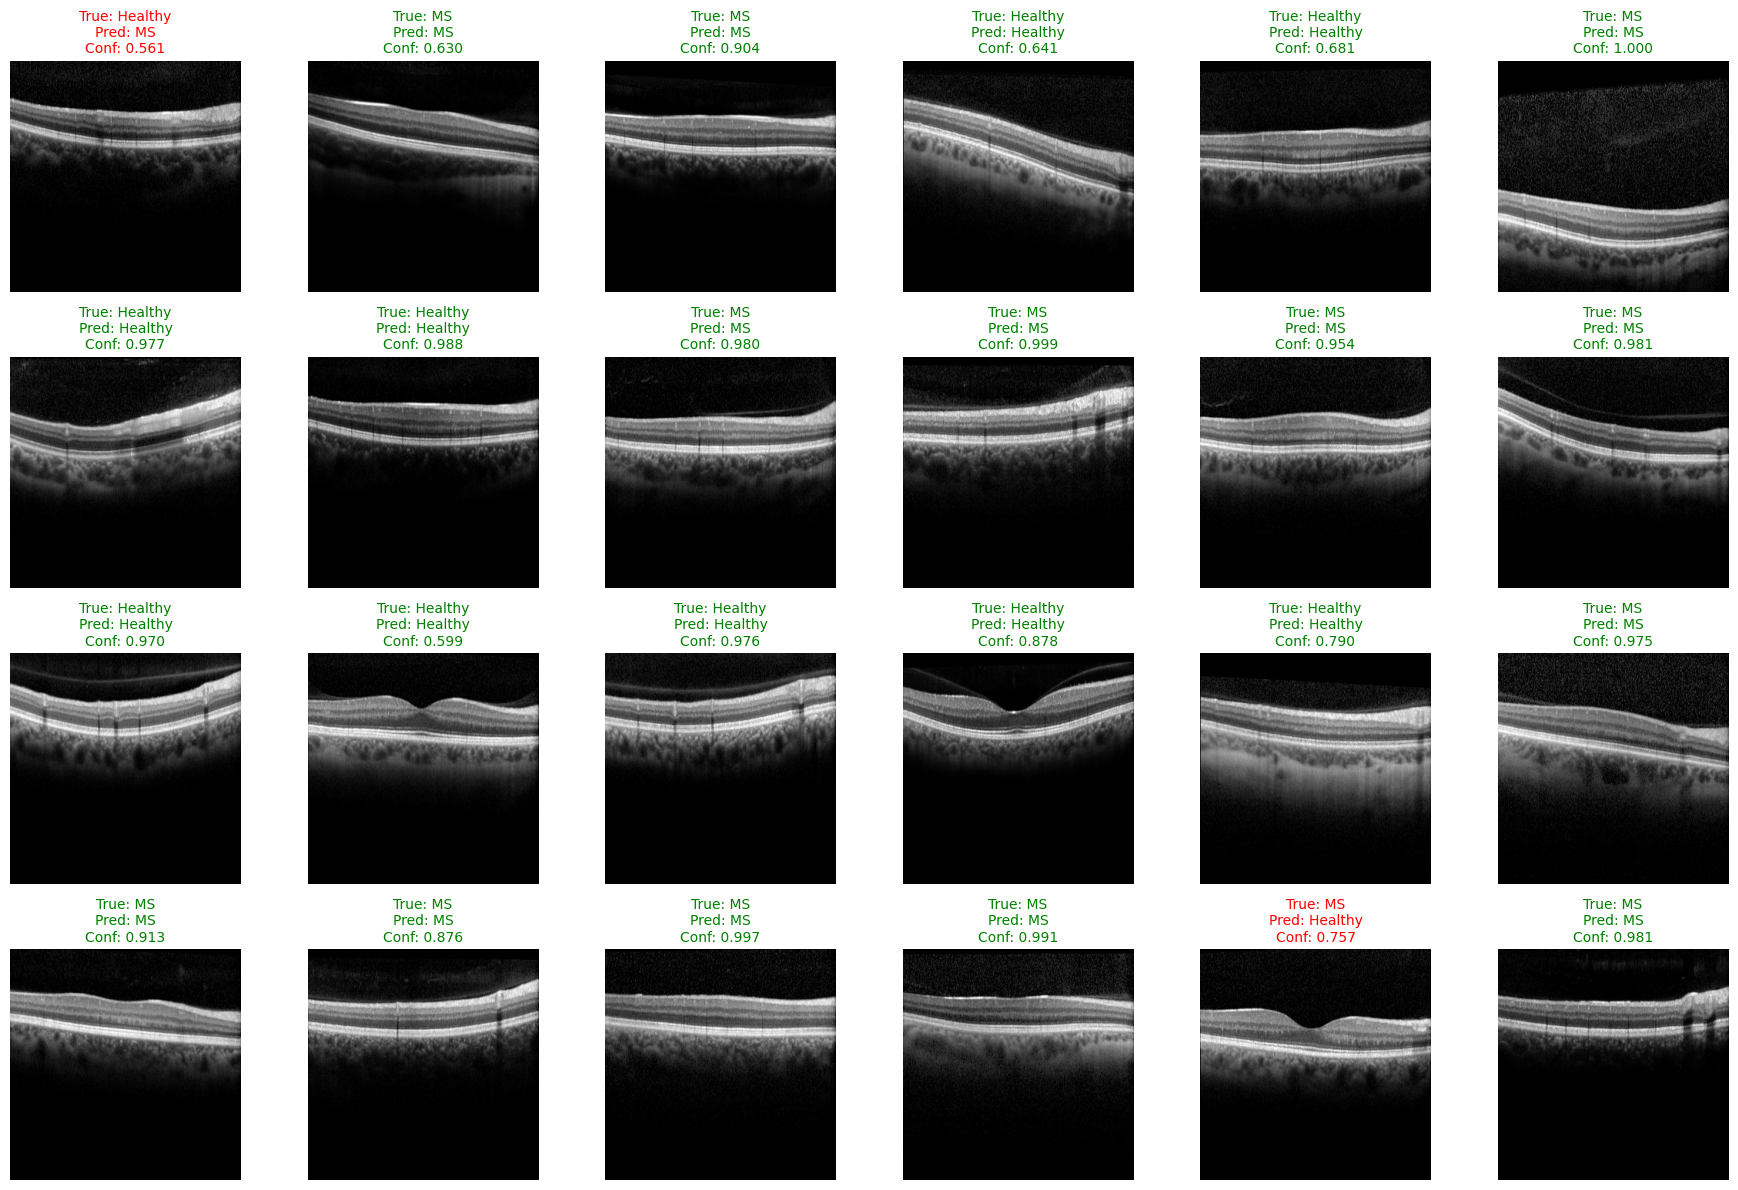

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(4, 6, figsize=(18, 12)) 
axes = axes.flatten()

counter = 0
max_images = 50

MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])

for i, (img, label) in enumerate(test_ds):
    if counter >= min(max_images, len(axes)):
        break

    prob = tta_probs[i]
    pred = tta_preds[i]
    true_label = y_true[i]

    if hasattr(img, 'numpy'):
        img_display = img.numpy()
    else:
        img_display = img

    if len(img_display.shape) == 4:
        img_display = img_display[0]

    # Convert from (channels, height, width) to (height, width, channels) for matplotlib
    if img_display.shape[0] == 3:  
        img_display = np.transpose(img_display, (1, 2, 0))

    # Denormalize the image
    img_display = img_display * STD + MEAN
    # Clip values to valid range [0, 1]
    img_display = np.clip(img_display, 0, 1)


    axes[counter].imshow(img_display)

    true_label_str = "MS" if true_label == 1 else "Healthy"
    pred_label_str = "MS" if pred == 1 else "Healthy"
    confidence = prob if pred == 1 else (1 - prob)

    caption = f"True: {true_label_str}\nPred: {pred_label_str}\nConf: {confidence:.3f}"

    color = 'green' if true_label == pred else 'red'

    axes[counter].set_title(caption, color=color, fontsize=10)
    axes[counter].axis('off')

    counter += 1

for i in range(counter, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()